In [1]:
import sys
import numpy as np
import scipy.io
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sys.path.append('/Users/juanesteban') 
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [3]:
class BoundaryConditionDataset(Dataset):

    def __init__(self, nb, lb, ub):
        """
        Constructor of the initial condition dataset
        Args:
          n0 (int)
        """
        super(type(self)).__init__()
        data = scipy.io.loadmat('/Users/juanesteban/PINNS/NeuralSolvers/examples/1D_Schroedinger/NLS.mat')
        t = data['tt'].flatten()[:, None]
        idx_t = np.random.choice(t.shape[0], nb, replace=False)
        tb = t[idx_t, :]
        self.x_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
        self.x_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)

    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.x_lb).float(), Tensor(self.x_ub).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1


In [4]:
class InitialConditionDataset(Dataset):

    def __init__(self, n0):
        """
        Constructor of the boundary condition dataset
        Args:
          n0 (int)
        """
        super(type(self)).__init__()
        data = scipy.io.loadmat('/Users/juanesteban/PINNS/NeuralSolvers/examples/1D_Schroedinger/NLS.mat')
        x = data['x'].flatten()[:, None]
        t = data['tt'].flatten()[:, None]
        Exact = data['uu']
        Exact_u = np.real(Exact)
        Exact_v = np.imag(Exact)
        idx_x = np.random.choice(x.shape[0], n0, replace=False)
        self.x = x[idx_x, :]
        self.u = Exact_u[idx_x, 0:1]
        self.v = Exact_v[idx_x, 0:1]
        self.t = np.zeros(self.x.shape)

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

    def __getitem__(self, idx):
        x = np.concatenate([self.x, self.t], axis=1)
        y = np.concatenate([self.u, self.v], axis=1)
        return Tensor(x).float(), Tensor(y)



In [5]:
class PDEDataset(Dataset):
    def __init__(self, nf, lb, ub):
        self.xf = lb + (ub - lb) * lhs(2, nf)

    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.xf).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1


if __name__ == "__main__":
    # Domain bounds
    lb = np.array([-5.0, 0.0])
    ub = np.array([5.0, np.pi / 2])
    # initial condition
    ic_dataset = InitialConditionDataset(n0=50)
    initial_condition = pf.InitialCondition(ic_dataset)
    # boundary conditions
    bc_dataset = BoundaryConditionDataset(nb=50, lb=lb, ub=ub)
    periodic_bc_u = pf.PeriodicBC(bc_dataset, 0, "u periodic boundary condition")
    periodic_bc_v = pf.PeriodicBC(bc_dataset, 1, "v periodic boundary condition")
    periodic_bc_u_x = pf.PeriodicBC(bc_dataset, 0, "u_x periodic boundary condition", 1, 0)
    periodic_bc_v_x = pf.PeriodicBC(bc_dataset, 1, "v_x periodic boundary condition", 1, 0)
    # PDE
    pde_dataset = PDEDataset(20000, lb, ub)


    def schroedinger1d(x, u):
        pred = u
        u = pred[:, 0]
        v = pred[:, 1]
        print("x:", x.shape)
        print("u:", v.shape)
        grads = ones(u.shape, device=pred.device) # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]
        grad_v = grad(v, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        print("u_x", u_x.shape)
        u_t = grad_u[:, 1]

        v_x = grad_v[:, 0]
        v_t = grad_v[:, 1]

        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        grad_v_x = grad(v_x, x, create_graph=True, grad_outputs=grads)[0]

        u_xx = grad_u_x[:, 0]
        print("u_xx", u_xx.shape)
        v_xx = grad_v_x[:, 0]
        f_u = u_t + u_x#0.5 * v_xx + (u ** 2 + v ** 2) * v
        print("f_u.shape", f_u.shape)
        f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
        print(f_u)
        return stack([f_u, f_v], 1)  # concatenate real part and imaginary part


    pde_loss = pf.PDELoss(pde_dataset, schroedinger1d)
    model = pf.models.MLP(input_size=2, output_size=2, hidden_size=100, num_hidden=4, lb=lb, ub=ub)
    pinn = pf.PINN(model, 2, 2, pde_loss, initial_condition, [periodic_bc_u,
                                                              periodic_bc_v,
                                                              periodic_bc_u_x,
                                                              periodic_bc_v_x], use_gpu=False)
    pinn.fit(200, 'Adam', 1e-3)

x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
tensor([-0.0858, -0.0841, -0.0901,  ..., -0.0570, -0.0906, -0.0959],
       grad_fn=<AddBackward0>)


/Users/juanesteban/PINNFramework/PDELoss.py:32: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:567.)
  C_b=torch.fft(f_i,1)


PINN Loss 79.41515473077727 Epoch 0 from 200
x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
tensor([-0.1434, -0.1992, -0.1638,  ..., -0.1399, -0.1760, -0.1919],
       grad_fn=<AddBackward0>)
PINN Loss 348.279412296952 Epoch 1 from 200
x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
tensor([-0.3238, -0.4242, -0.3632,  ..., -0.3167, -0.3855, -0.4139],
       grad_fn=<AddBackward0>)
PINN Loss 1615.8809849009224 Epoch 2 from 200
x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
tensor([-0.5162, -0.6413, -0.5740,  ..., -0.4868, -0.6017, -0.6399],
       grad_fn=<AddBackward0>)
PINN Loss 3811.197515282246 Epoch 3 from 200


KeyboardInterrupt: 

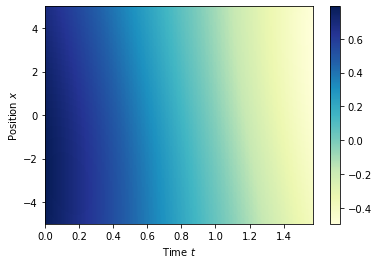

In [6]:
 # Plotting
data = scipy.io.loadmat('/Users/juanesteban/PINNS/NeuralSolvers/examples/1D_Schroedinger/NLS.mat')
t = data['tt'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u ** 2 + Exact_v ** 2)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None]
v_star = Exact_v.T.flatten()[:, None]
h_star = Exact_h.T.flatten()[:, None]

pred = model(Tensor(X_star).cpu())
pred_u = pred[:, 0].detach().cpu().numpy()
pred_v = pred[:, 1].detach().cpu().numpy()
H_pred = np.sqrt(pred_u ** 2 + pred_v**2)
H_pred = H_pred.reshape(X.shape)
plt.imshow(pred_u.reshape(X.shape).T, interpolation='nearest', cmap='YlGnBu',
              extent= [lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')
plt.xlabel('Time $t$')
plt.ylabel('Position $x$')
plt.colorbar()
plt.show()

In [7]:
import torch
from torch import Tensor as Tensor
from torch.nn import Module as Module
from torch.nn import MSELoss, L1Loss
from PINNFramework.LossTerm import LossTerm


class PDE_Loss(LossTerm):
    def __init__(self, dataset, pde, norm='L2', weight=1.):
        """
        Constructor of the PDE Loss
        Args:
            dataset (torch.utils.Dataset): dataset that provides the residual points
            pde (function): function that represents residual of the PDE
            norm: Norm used for calculation PDE loss
            weight: Weighting for the loss term
        """
        super(PDELoss, self).__init__(dataset, norm, weight)
        self.dataset = dataset
        self.pde = pde
    def i_star(f_i):
        C_b=torch.fft(f_i,1)
        f_star=[complex(*C_b[j])/(2*np.pi*j)*
                np.exp(2*np.pi*np.exp(complex(0,1)*j*2)) for j in range(1,len(C_b))]
        return [complex(*C_b[0]),*f_star]
    def __call__(self, x: Tensor, model: Module, **kwargs):
        """
        Call function of the PDE loss. Calculates the norm of the PDE residual
        x: residual points
        model: model that predicts the solution of the PDE
        """
        x.requires_grad = True  # setting requires grad to true in order to calculate
        u = model.forward(x)
        pde_residual = self.pde(x, u, **kwargs)
        #pde_residual = i_star(pde_residual)#torch.fft(pde_residual,1)
        zeros = torch.zeros(pde_residual.shape, device=pde_residual.device)
        return self.norm(pde_residual, zeros)

In [8]:
class PDEDataset(Dataset):
    def __init__(self, nf, lb, ub):
        self.xf = lb + (ub - lb) * lhs(2, nf)

    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.xf).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1


if __name__ == "__main__":
    # Domain bounds
    lb = np.array([-5.0, 0.0])
    ub = np.array([5.0, np.pi / 2])
    # initial condition
    ic_dataset = InitialConditionDataset(n0=50)
    initial_condition = pf.InitialCondition(ic_dataset)
    # boundary conditions
    bc_dataset = BoundaryConditionDataset(nb=50, lb=lb, ub=ub)
    periodic_bc_u = pf.PeriodicBC(bc_dataset, 0, "u periodic boundary condition")
    periodic_bc_v = pf.PeriodicBC(bc_dataset, 1, "v periodic boundary condition")
    periodic_bc_u_x = pf.PeriodicBC(bc_dataset, 0, "u_x periodic boundary condition", 1, 0)
    periodic_bc_v_x = pf.PeriodicBC(bc_dataset, 1, "v_x periodic boundary condition", 1, 0)
    # PDE
    pde_dataset = PDEDataset(20000, lb, ub)


    def schroedinger1d(x, u):
        pred = u
        u = pred[:, 0]
        v = pred[:, 1]
        print("x:", x.shape)
        print("u:", v.shape)
        grads = ones(u.shape, device=pred.device) # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]
        grad_v = grad(v, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        print("u_x", u_x.shape)
        u_t = grad_u[:, 1]

        v_x = grad_v[:, 0]
        v_t = grad_v[:, 1]

        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
        grad_v_x = grad(v_x, x, create_graph=True, grad_outputs=grads)[0]

        u_xx = grad_u_x[:, 0]
        print("u_xx", u_xx.shape)
        v_xx = grad_v_x[:, 0]
        f_u = u_t + u_x#0.5 * v_xx + (u ** 2 + v ** 2) * v
        print("f_u.shape", f_u.shape)
        f_v = 0*v_t# - 0.5 * u_xx - (u ** 2 + v ** 2) * u
        return stack([f_u, f_v], 1)  # concatenate real part and imaginary part


    pde_loss = pf.PDELoss(pde_dataset, schroedinger1d)
    model = pf.models.MLP(input_size=2, output_size=2, hidden_size=100, num_hidden=4, lb=lb, ub=ub)
    pinn = pf.PINN(model, 2, 2, pde_loss, initial_condition, [periodic_bc_u,
                                                              periodic_bc_v,
                                                              periodic_bc_u_x,
                                                              periodic_bc_v_x], use_gpu=False)
    pinn.fit(2, 'Adam', 1e-3)

x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
PINN Loss 57.99028655533938 Epoch 0 from 2
x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
PINN Loss 1075.405699904906 Epoch 1 from 2
x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
x: torch.Size([20000, 2])
u: torch.Size([20000])
u_x torch.Size([20000])
u_xx torch.Size([20000])
f_u.shape torch.Size([20000])
x: torch.Size([200

In [9]:
inp =  torch.rand([4, 2])
C_b=torch.fft(inp,1)
inp

tensor([[0.2541, 0.7265],
        [0.1515, 0.6304],
        [0.7618, 0.8249],
        [0.6845, 0.2284]])

In [10]:
def FT(f_i,x):
    C_b=torch.fft(f_i,1)
    f_star = np.sum([complex(*C_b[j])*np.exp(np.pi*complex(0,1)*j*x) for j in range(len(C_b))])
    return f_star

In [11]:
FT(inp,1)

(3.0470686554908757+3.2995018959045406j)

In [12]:
torch.fft(inp,1)

tensor([[ 1.8518,  2.4102],
        [-0.1056,  0.4346],
        [ 0.1798,  0.6926],
        [-0.9098, -0.6313]])

In [13]:
C_b=torch.fft(inp,1)
x=0.3
np.sum([complex(*C_b[j])*np.exp(np.pi*complex(0,1)*j*x) for j in range(len(C_b))])

(1.784220259531072+2.856485235371169j)